# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

    100% |████████████████████████████████| 14.6MB 35kB/s  eta 0:00:01
  Found existing installation: matplotlib 2.1.0
    Uninstalling matplotlib-2.1.0:
      Successfully uninstalled matplotlib-2.1.0
You are using pip version 9.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

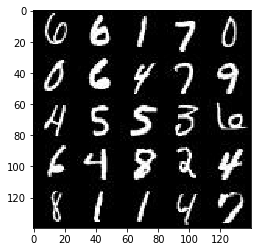

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

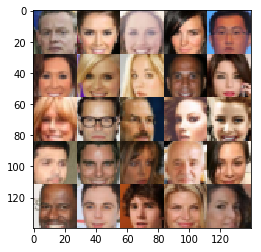

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha = 0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 128, 5, padding='same', strides=2,
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x1 = tf.layers.average_pooling2d(x1, pool_size=2, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1, rate=0.25, training=True)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 256, 5, padding='same', strides=2,
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        #x2 = tf.layers.average_pooling2d(x2, pool_size=2, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2, rate=0.35, training=True)
        # 7x7x128
        
#        x3 = tf.layers.conv2d(x2, 256, 5, padding='same', strides=1,
#                              kernel_initializer=tf.contrib.layers.xavier_initializer())
#        #x3 = tf.layers.average_pooling2d(x3, pool_size=2, strides=2, padding='same')
#        x3 = tf.layers.batch_normalization(x3, training=True)
#        x3 = tf.maximum(alpha * x3, x3)
#        x3 = tf.layers.dropout(x3, rate=0.5, training=True)
        # 7x7x256
        
        # Flatten it
        flat = tf.reshape(x2, (-1, 7*7*256))
        
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.dropout(x1, rate=0.5, training=is_train)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, padding='same', strides=2,
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(x2, rate=0.25, training=is_train)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, padding='same', strides=1,
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(x3, rate=0.2, training=is_train)
        # 14x14x128 now
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, padding='same', strides=1,
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.layers.dropout(x4, rate=0.15, training=is_train)
        # 14x14x64 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same')
        # 28x28 now
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha = 0.1,
         print_every=20, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3], alpha=alpha)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    #losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images*2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim=data_shape[3], image_mode=data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.3939... Generator Loss: 1.6161
Epoch 1/2... Discriminator Loss: 0.8529... Generator Loss: 1.9891
Epoch 1/2... Discriminator Loss: 0.9971... Generator Loss: 1.3470
Epoch 1/2... Discriminator Loss: 1.1645... Generator Loss: 1.0618
Epoch 1/2... Discriminator Loss: 2.5849... Generator Loss: 0.4365


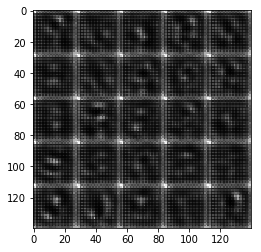

Epoch 1/2... Discriminator Loss: 1.4681... Generator Loss: 0.9674
Epoch 1/2... Discriminator Loss: 1.5042... Generator Loss: 0.6974
Epoch 1/2... Discriminator Loss: 1.3112... Generator Loss: 1.3702
Epoch 1/2... Discriminator Loss: 1.2903... Generator Loss: 0.7445
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 1.7399


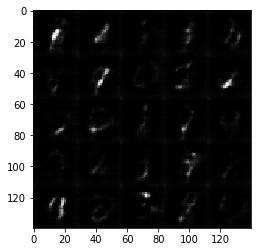

Epoch 1/2... Discriminator Loss: 1.2912... Generator Loss: 1.4077
Epoch 1/2... Discriminator Loss: 1.3734... Generator Loss: 1.1500
Epoch 1/2... Discriminator Loss: 1.4164... Generator Loss: 1.1929
Epoch 1/2... Discriminator Loss: 1.2614... Generator Loss: 1.4948
Epoch 1/2... Discriminator Loss: 1.4858... Generator Loss: 1.7904


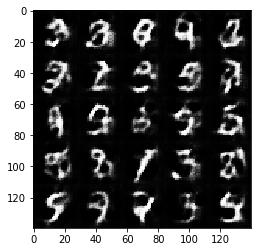

Epoch 1/2... Discriminator Loss: 1.6392... Generator Loss: 0.6352
Epoch 1/2... Discriminator Loss: 1.4638... Generator Loss: 1.0516
Epoch 1/2... Discriminator Loss: 1.3569... Generator Loss: 1.0084
Epoch 1/2... Discriminator Loss: 1.4192... Generator Loss: 0.5933
Epoch 1/2... Discriminator Loss: 1.4499... Generator Loss: 0.5743


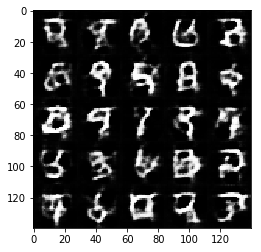

Epoch 1/2... Discriminator Loss: 1.2391... Generator Loss: 1.0305
Epoch 1/2... Discriminator Loss: 1.1895... Generator Loss: 1.1493
Epoch 1/2... Discriminator Loss: 1.2915... Generator Loss: 0.6304
Epoch 1/2... Discriminator Loss: 1.4707... Generator Loss: 1.0979
Epoch 1/2... Discriminator Loss: 1.4301... Generator Loss: 0.9438


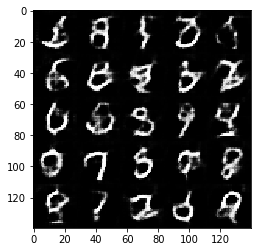

Epoch 1/2... Discriminator Loss: 1.2551... Generator Loss: 1.0657
Epoch 1/2... Discriminator Loss: 1.3049... Generator Loss: 0.8260
Epoch 1/2... Discriminator Loss: 1.3881... Generator Loss: 0.8448
Epoch 1/2... Discriminator Loss: 1.2040... Generator Loss: 0.7719
Epoch 1/2... Discriminator Loss: 1.4198... Generator Loss: 0.6085


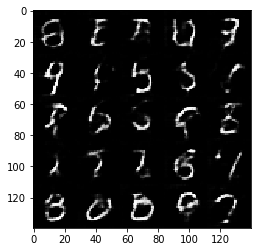

Epoch 1/2... Discriminator Loss: 1.2640... Generator Loss: 0.6550
Epoch 1/2... Discriminator Loss: 1.4784... Generator Loss: 0.7082
Epoch 1/2... Discriminator Loss: 1.4287... Generator Loss: 0.9804
Epoch 1/2... Discriminator Loss: 1.8730... Generator Loss: 1.5800
Epoch 1/2... Discriminator Loss: 1.2901... Generator Loss: 0.8488


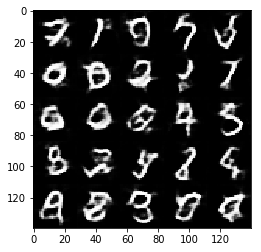

Epoch 1/2... Discriminator Loss: 1.3824... Generator Loss: 1.0210
Epoch 1/2... Discriminator Loss: 1.1189... Generator Loss: 0.8821
Epoch 1/2... Discriminator Loss: 1.4794... Generator Loss: 1.1263
Epoch 1/2... Discriminator Loss: 1.1132... Generator Loss: 0.8968
Epoch 1/2... Discriminator Loss: 1.2022... Generator Loss: 0.6379


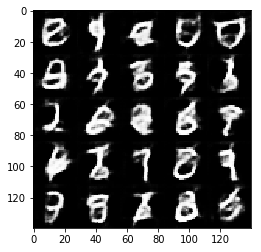

Epoch 1/2... Discriminator Loss: 1.8000... Generator Loss: 1.2478
Epoch 1/2... Discriminator Loss: 1.4299... Generator Loss: 0.6920
Epoch 1/2... Discriminator Loss: 1.0840... Generator Loss: 0.8875
Epoch 1/2... Discriminator Loss: 1.5411... Generator Loss: 0.9371
Epoch 1/2... Discriminator Loss: 1.2229... Generator Loss: 0.6526


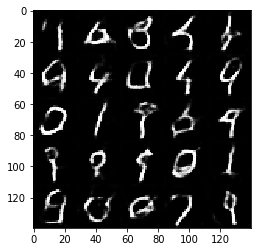

Epoch 1/2... Discriminator Loss: 1.4078... Generator Loss: 1.0658
Epoch 1/2... Discriminator Loss: 1.3985... Generator Loss: 0.8034
Epoch 1/2... Discriminator Loss: 1.3245... Generator Loss: 1.0507
Epoch 1/2... Discriminator Loss: 1.1972... Generator Loss: 0.7682
Epoch 1/2... Discriminator Loss: 1.0988... Generator Loss: 0.8904


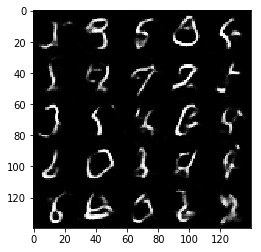

Epoch 1/2... Discriminator Loss: 1.1211... Generator Loss: 0.8776
Epoch 1/2... Discriminator Loss: 1.2690... Generator Loss: 1.0092
Epoch 1/2... Discriminator Loss: 1.3619... Generator Loss: 0.7035
Epoch 1/2... Discriminator Loss: 1.7516... Generator Loss: 0.5973
Epoch 1/2... Discriminator Loss: 1.4451... Generator Loss: 1.2022


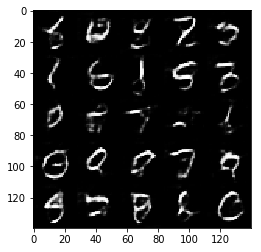

Epoch 1/2... Discriminator Loss: 1.2139... Generator Loss: 0.9910
Epoch 1/2... Discriminator Loss: 1.2045... Generator Loss: 0.7974
Epoch 1/2... Discriminator Loss: 1.3321... Generator Loss: 1.2997
Epoch 1/2... Discriminator Loss: 1.1585... Generator Loss: 1.0864
Epoch 1/2... Discriminator Loss: 1.1323... Generator Loss: 0.8084


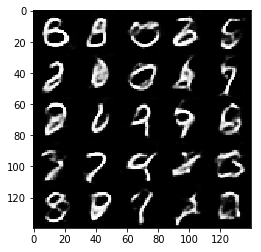

Epoch 1/2... Discriminator Loss: 1.2629... Generator Loss: 0.7737
Epoch 1/2... Discriminator Loss: 1.0646... Generator Loss: 1.1045
Epoch 1/2... Discriminator Loss: 1.4926... Generator Loss: 0.9027
Epoch 1/2... Discriminator Loss: 1.2651... Generator Loss: 1.2325
Epoch 1/2... Discriminator Loss: 1.4582... Generator Loss: 0.6127


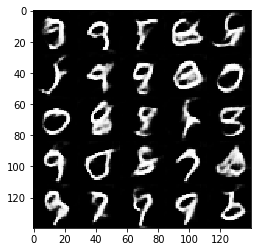

Epoch 1/2... Discriminator Loss: 1.4965... Generator Loss: 0.5327
Epoch 1/2... Discriminator Loss: 1.2788... Generator Loss: 1.0702
Epoch 1/2... Discriminator Loss: 1.1201... Generator Loss: 1.0892
Epoch 1/2... Discriminator Loss: 0.9502... Generator Loss: 0.9407
Epoch 1/2... Discriminator Loss: 1.3422... Generator Loss: 0.7537


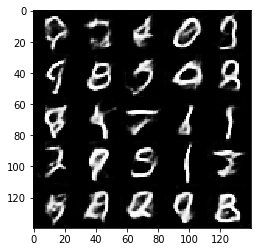

Epoch 1/2... Discriminator Loss: 1.1896... Generator Loss: 0.9203
Epoch 1/2... Discriminator Loss: 1.2624... Generator Loss: 0.8692
Epoch 1/2... Discriminator Loss: 1.3610... Generator Loss: 0.6709
Epoch 1/2... Discriminator Loss: 1.3071... Generator Loss: 0.5676
Epoch 1/2... Discriminator Loss: 1.1221... Generator Loss: 1.0771


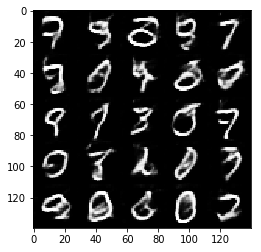

Epoch 1/2... Discriminator Loss: 1.0416... Generator Loss: 0.9168
Epoch 1/2... Discriminator Loss: 1.3421... Generator Loss: 1.3479
Epoch 1/2... Discriminator Loss: 1.2440... Generator Loss: 1.0081
Epoch 1/2... Discriminator Loss: 1.2790... Generator Loss: 0.6235
Epoch 1/2... Discriminator Loss: 1.3202... Generator Loss: 0.6690


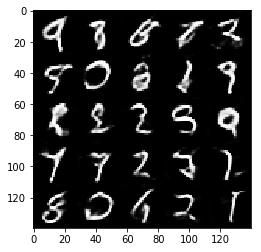

Epoch 1/2... Discriminator Loss: 1.5813... Generator Loss: 0.4960
Epoch 1/2... Discriminator Loss: 1.1273... Generator Loss: 1.3239
Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 0.8636
Epoch 1/2... Discriminator Loss: 1.1338... Generator Loss: 0.6071
Epoch 1/2... Discriminator Loss: 1.1378... Generator Loss: 1.0580


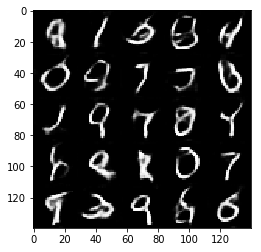

Epoch 1/2... Discriminator Loss: 1.2253... Generator Loss: 0.5872
Epoch 1/2... Discriminator Loss: 1.4406... Generator Loss: 0.5377
Epoch 1/2... Discriminator Loss: 1.1525... Generator Loss: 1.2434
Epoch 1/2... Discriminator Loss: 1.2693... Generator Loss: 0.9304
Epoch 1/2... Discriminator Loss: 1.4833... Generator Loss: 0.6372


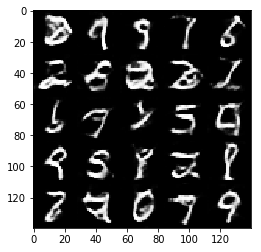

Epoch 1/2... Discriminator Loss: 1.2871... Generator Loss: 1.0341
Epoch 1/2... Discriminator Loss: 1.3844... Generator Loss: 0.8018
Epoch 1/2... Discriminator Loss: 1.3054... Generator Loss: 1.1862
Epoch 2/2... Discriminator Loss: 1.4488... Generator Loss: 0.6442
Epoch 2/2... Discriminator Loss: 1.1333... Generator Loss: 0.7619


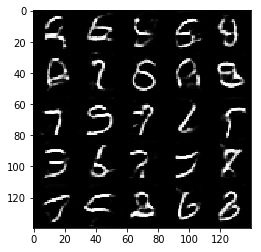

Epoch 2/2... Discriminator Loss: 1.3931... Generator Loss: 1.2105
Epoch 2/2... Discriminator Loss: 1.3619... Generator Loss: 1.4079
Epoch 2/2... Discriminator Loss: 1.0265... Generator Loss: 0.8731
Epoch 2/2... Discriminator Loss: 1.4029... Generator Loss: 1.2312
Epoch 2/2... Discriminator Loss: 1.0761... Generator Loss: 1.1060


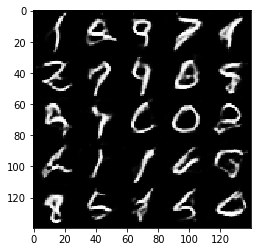

Epoch 2/2... Discriminator Loss: 1.1740... Generator Loss: 1.1593
Epoch 2/2... Discriminator Loss: 1.3064... Generator Loss: 0.8442
Epoch 2/2... Discriminator Loss: 1.3267... Generator Loss: 1.0494
Epoch 2/2... Discriminator Loss: 1.2058... Generator Loss: 1.4728
Epoch 2/2... Discriminator Loss: 1.4081... Generator Loss: 0.6398


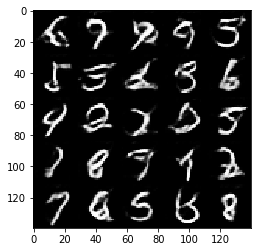

Epoch 2/2... Discriminator Loss: 1.2273... Generator Loss: 0.9952
Epoch 2/2... Discriminator Loss: 1.2244... Generator Loss: 0.7061
Epoch 2/2... Discriminator Loss: 1.0928... Generator Loss: 1.1838
Epoch 2/2... Discriminator Loss: 1.2467... Generator Loss: 0.9690
Epoch 2/2... Discriminator Loss: 1.3456... Generator Loss: 0.8134


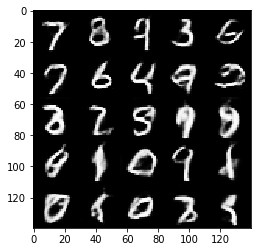

Epoch 2/2... Discriminator Loss: 1.1754... Generator Loss: 0.8846
Epoch 2/2... Discriminator Loss: 1.0985... Generator Loss: 1.1327
Epoch 2/2... Discriminator Loss: 1.0416... Generator Loss: 0.7505
Epoch 2/2... Discriminator Loss: 1.4367... Generator Loss: 0.6627
Epoch 2/2... Discriminator Loss: 1.2887... Generator Loss: 1.0528


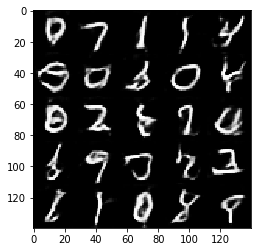

Epoch 2/2... Discriminator Loss: 1.0358... Generator Loss: 1.0435
Epoch 2/2... Discriminator Loss: 1.2799... Generator Loss: 1.2424
Epoch 2/2... Discriminator Loss: 1.2605... Generator Loss: 1.0151
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 1.1574
Epoch 2/2... Discriminator Loss: 1.3567... Generator Loss: 0.8510


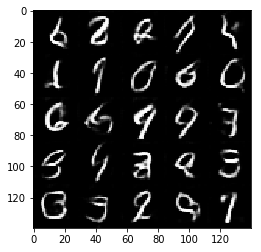

Epoch 2/2... Discriminator Loss: 1.2148... Generator Loss: 1.0567
Epoch 2/2... Discriminator Loss: 1.2449... Generator Loss: 0.6673
Epoch 2/2... Discriminator Loss: 1.3372... Generator Loss: 0.7928
Epoch 2/2... Discriminator Loss: 1.1022... Generator Loss: 1.1596
Epoch 2/2... Discriminator Loss: 1.1410... Generator Loss: 0.9555


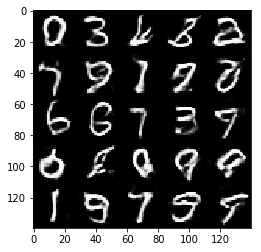

Epoch 2/2... Discriminator Loss: 1.2245... Generator Loss: 0.8163
Epoch 2/2... Discriminator Loss: 1.2877... Generator Loss: 1.4255
Epoch 2/2... Discriminator Loss: 1.4659... Generator Loss: 1.2537
Epoch 2/2... Discriminator Loss: 1.2237... Generator Loss: 0.9765
Epoch 2/2... Discriminator Loss: 1.1978... Generator Loss: 0.8880


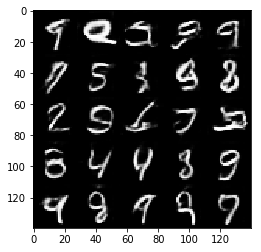

Epoch 2/2... Discriminator Loss: 1.0863... Generator Loss: 0.9411
Epoch 2/2... Discriminator Loss: 1.1690... Generator Loss: 1.1809
Epoch 2/2... Discriminator Loss: 1.1712... Generator Loss: 0.7832
Epoch 2/2... Discriminator Loss: 1.1692... Generator Loss: 1.0655
Epoch 2/2... Discriminator Loss: 1.1351... Generator Loss: 1.0451


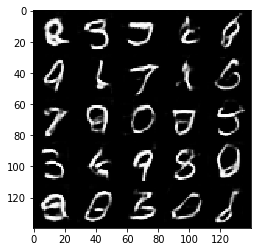

Epoch 2/2... Discriminator Loss: 1.1537... Generator Loss: 0.8052
Epoch 2/2... Discriminator Loss: 1.2516... Generator Loss: 1.2383
Epoch 2/2... Discriminator Loss: 1.1381... Generator Loss: 0.7566
Epoch 2/2... Discriminator Loss: 1.0774... Generator Loss: 1.5975
Epoch 2/2... Discriminator Loss: 1.0993... Generator Loss: 0.9547


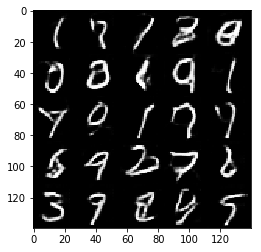

Epoch 2/2... Discriminator Loss: 0.9847... Generator Loss: 1.1841
Epoch 2/2... Discriminator Loss: 1.1827... Generator Loss: 1.3529
Epoch 2/2... Discriminator Loss: 1.2436... Generator Loss: 0.9708
Epoch 2/2... Discriminator Loss: 1.3734... Generator Loss: 1.0586
Epoch 2/2... Discriminator Loss: 1.3530... Generator Loss: 0.6160


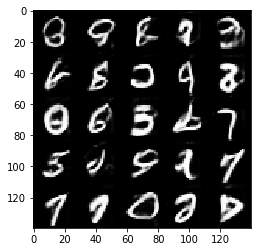

Epoch 2/2... Discriminator Loss: 0.9461... Generator Loss: 1.4669
Epoch 2/2... Discriminator Loss: 1.2594... Generator Loss: 0.7494
Epoch 2/2... Discriminator Loss: 1.2002... Generator Loss: 0.9185
Epoch 2/2... Discriminator Loss: 1.1026... Generator Loss: 0.9491
Epoch 2/2... Discriminator Loss: 1.2412... Generator Loss: 0.8319


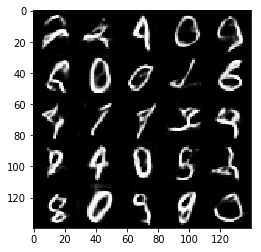

Epoch 2/2... Discriminator Loss: 1.0031... Generator Loss: 1.1174
Epoch 2/2... Discriminator Loss: 1.0255... Generator Loss: 0.9843
Epoch 2/2... Discriminator Loss: 1.2684... Generator Loss: 1.1378
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.7020
Epoch 2/2... Discriminator Loss: 1.2996... Generator Loss: 0.8691


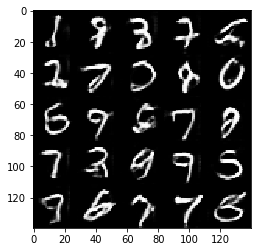

Epoch 2/2... Discriminator Loss: 1.1553... Generator Loss: 1.0613
Epoch 2/2... Discriminator Loss: 1.1958... Generator Loss: 1.2047
Epoch 2/2... Discriminator Loss: 0.9762... Generator Loss: 1.0051
Epoch 2/2... Discriminator Loss: 1.3910... Generator Loss: 0.6911
Epoch 2/2... Discriminator Loss: 1.0790... Generator Loss: 1.1456


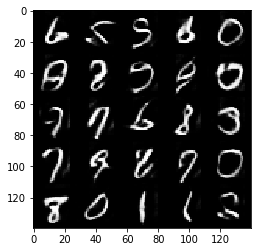

Epoch 2/2... Discriminator Loss: 1.1816... Generator Loss: 0.7565
Epoch 2/2... Discriminator Loss: 1.2541... Generator Loss: 0.9191
Epoch 2/2... Discriminator Loss: 0.9151... Generator Loss: 1.1031
Epoch 2/2... Discriminator Loss: 1.1719... Generator Loss: 1.1540
Epoch 2/2... Discriminator Loss: 1.2544... Generator Loss: 0.9924


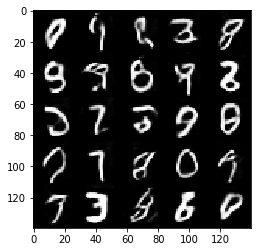

Epoch 2/2... Discriminator Loss: 1.1049... Generator Loss: 0.8923
Epoch 2/2... Discriminator Loss: 1.2107... Generator Loss: 0.7801
Epoch 2/2... Discriminator Loss: 1.0760... Generator Loss: 0.8943
Epoch 2/2... Discriminator Loss: 1.1691... Generator Loss: 0.7931
Epoch 2/2... Discriminator Loss: 1.3300... Generator Loss: 0.8426


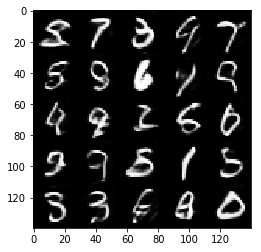

Epoch 2/2... Discriminator Loss: 1.1021... Generator Loss: 1.2001
Epoch 2/2... Discriminator Loss: 1.1062... Generator Loss: 1.0620
Epoch 2/2... Discriminator Loss: 1.0119... Generator Loss: 0.7202
Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 1.6462
Epoch 2/2... Discriminator Loss: 1.4616... Generator Loss: 0.5355


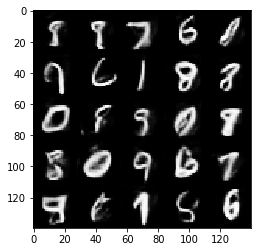

Epoch 2/2... Discriminator Loss: 1.2566... Generator Loss: 0.9134
Epoch 2/2... Discriminator Loss: 1.3121... Generator Loss: 0.8487
Epoch 2/2... Discriminator Loss: 0.9953... Generator Loss: 0.7997
Epoch 2/2... Discriminator Loss: 1.0006... Generator Loss: 1.2937
Epoch 2/2... Discriminator Loss: 1.1948... Generator Loss: 0.8600


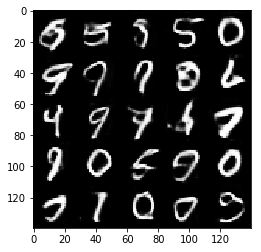

Epoch 2/2... Discriminator Loss: 1.2223... Generator Loss: 1.3505
Epoch 2/2... Discriminator Loss: 1.2034... Generator Loss: 0.8280
Epoch 2/2... Discriminator Loss: 0.8454... Generator Loss: 1.1038
Epoch 2/2... Discriminator Loss: 1.3038... Generator Loss: 0.8228
Epoch 2/2... Discriminator Loss: 1.0293... Generator Loss: 0.9524


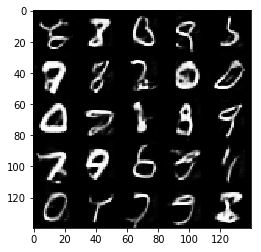

Epoch 2/2... Discriminator Loss: 1.0537... Generator Loss: 1.2880
Epoch 2/2... Discriminator Loss: 1.3767... Generator Loss: 0.6972
CPU times: user 6min 6s, sys: 2min 4s, total: 8min 11s
Wall time: 9min 43s


In [12]:
%%time
batch_size = 32
z_dim = 100
learning_rate = 0.0008
alpha = 0.18
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha = alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.2485... Generator Loss: 1.8137
Epoch 1/1... Discriminator Loss: 1.5603... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 0.6357... Generator Loss: 1.1308
Epoch 1/1... Discriminator Loss: 0.5620... Generator Loss: 1.9653
Epoch 1/1... Discriminator Loss: 0.6725... Generator Loss: 1.0992


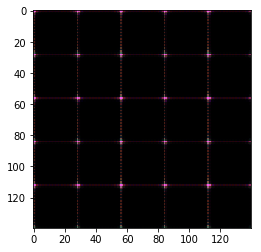

Epoch 1/1... Discriminator Loss: 0.6389... Generator Loss: 4.3593
Epoch 1/1... Discriminator Loss: 0.7294... Generator Loss: 1.0930
Epoch 1/1... Discriminator Loss: 0.5659... Generator Loss: 3.3053
Epoch 1/1... Discriminator Loss: 0.5627... Generator Loss: 2.8559
Epoch 1/1... Discriminator Loss: 0.6728... Generator Loss: 1.0254


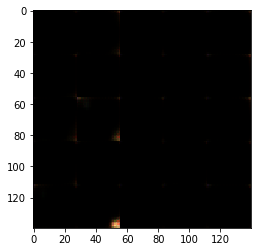

Epoch 1/1... Discriminator Loss: 0.5951... Generator Loss: 1.3341
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 1.4080
Epoch 1/1... Discriminator Loss: 0.5645... Generator Loss: 2.0825
Epoch 1/1... Discriminator Loss: 0.7807... Generator Loss: 1.0114


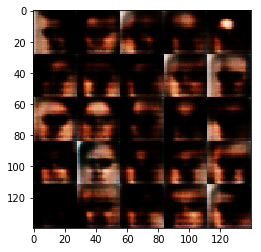

Epoch 1/1... Discriminator Loss: 0.6666... Generator Loss: 0.9887
Epoch 1/1... Discriminator Loss: 0.6037... Generator Loss: 1.6640
Epoch 1/1... Discriminator Loss: 0.9617... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 0.5593... Generator Loss: 1.4334


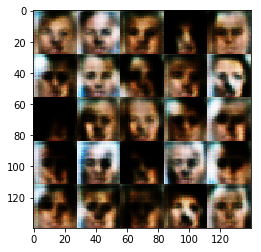

Epoch 1/1... Discriminator Loss: 0.7261... Generator Loss: 1.1070
Epoch 1/1... Discriminator Loss: 0.6627... Generator Loss: 1.8260
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 0.7280... Generator Loss: 1.5551
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 2.3287


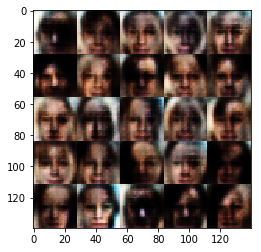

Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 2.0274
Epoch 1/1... Discriminator Loss: 0.7904... Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 0.8329... Generator Loss: 1.6282
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 2.8426
Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 1.5169


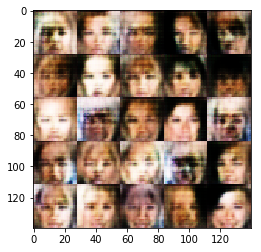

Epoch 1/1... Discriminator Loss: 0.9325... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 2.1689
Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 2.0907


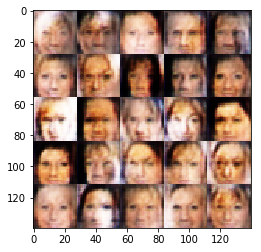

Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 1.7416
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.4557
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 1.8060
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 1.6461
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 0.7484


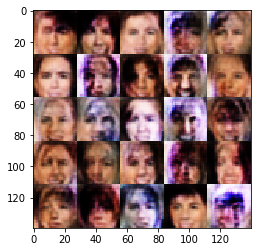

Epoch 1/1... Discriminator Loss: 0.8748... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 1.5130
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 1.4752
Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 1.0901


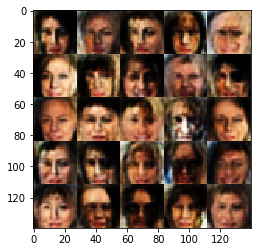

Epoch 1/1... Discriminator Loss: 0.8936... Generator Loss: 0.9840
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 1.4114
Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 1.2951
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 1.3991


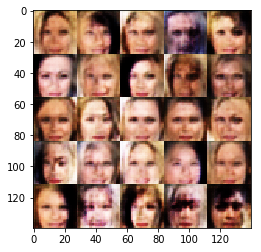

Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 1.0495
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.1100... Generator Loss: 0.5075
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.9229


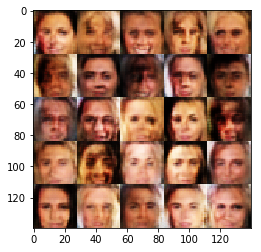

Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 1.2267
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.5409
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 1.0880
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 1.8907
Epoch 1/1... Discriminator Loss: 1.0485... Generator Loss: 1.2057


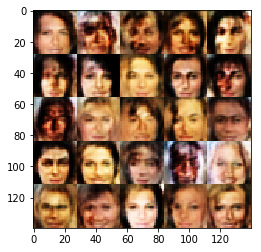

Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 1.0992
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 1.0999
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 0.9574
Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 1.3473


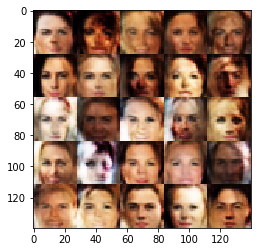

Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 1.2269
Epoch 1/1... Discriminator Loss: 1.0523... Generator Loss: 1.4360
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.9490
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 1.7510
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 1.4039


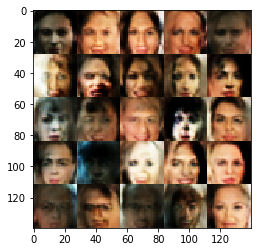

Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.1148... Generator Loss: 1.1971
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 1.2612
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 1.6908
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 1.4089


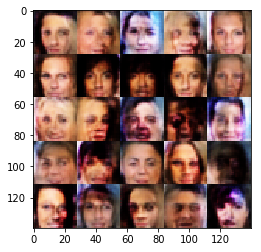

Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 1.0647... Generator Loss: 1.7045
Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.7197
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.8055


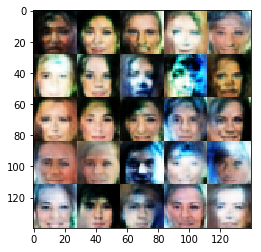

Epoch 1/1... Discriminator Loss: 1.0369... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 1.2017
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 0.7866
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 1.5841


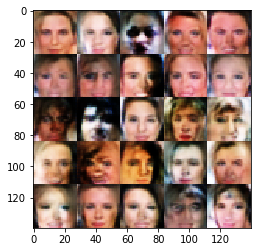

Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 1.4323
Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 0.8160
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 1.3108
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 1.2176


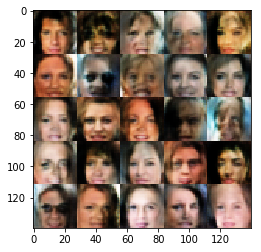

Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 1.4262
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 1.2219


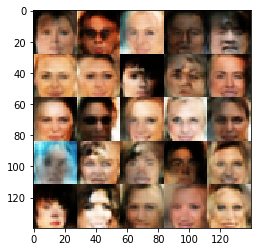

Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.8653
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 1.0338
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 0.9130


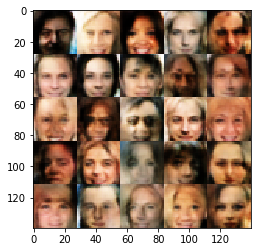

Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 1.6584
Epoch 1/1... Discriminator Loss: 1.0882... Generator Loss: 1.2088
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 1.3617
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 1.0990


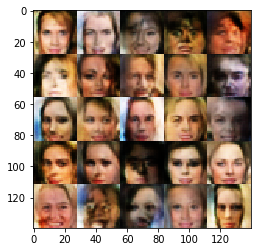

Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 1.0414
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 0.8952
Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 1.5392


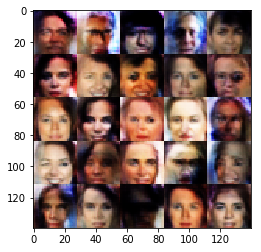

Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 0.9396
Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 1.0397
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 1.3946
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 1.0157


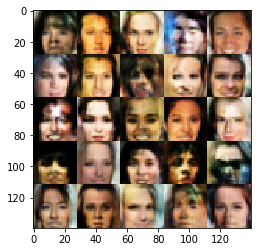

Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 1.4508
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.0163... Generator Loss: 1.0256


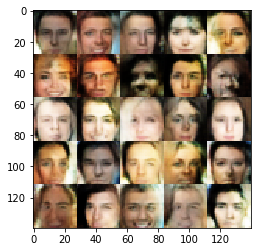

Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.9517
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 1.6592
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 1.6403
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 1.3737


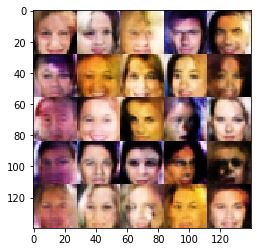

Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 1.0552
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 1.0729
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.8466
Epoch 1/1... Discriminator Loss: 1.0006... Generator Loss: 1.0501


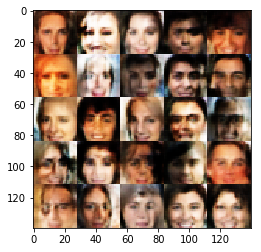

Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.3913
Epoch 1/1... Discriminator Loss: 1.0440... Generator Loss: 1.0186
Epoch 1/1... Discriminator Loss: 1.0344... Generator Loss: 1.2233
Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.5345


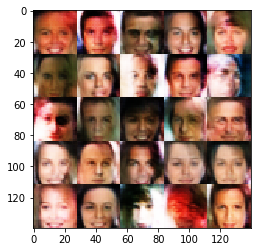

Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 1.4142
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 0.9418
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 1.1932
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.0702... Generator Loss: 1.4078


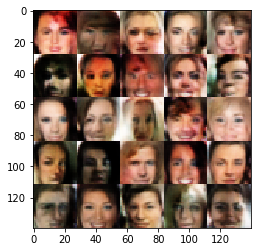

Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.9782
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 1.1788


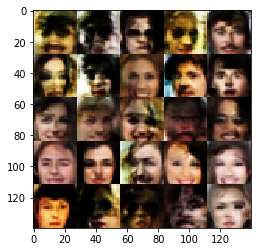

Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 1.5090
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 1.2879
Epoch 1/1... Discriminator Loss: 1.1161... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 1.2099


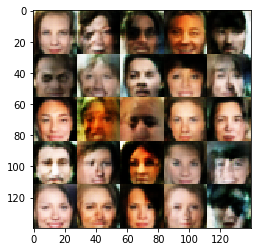

Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 1.8636
Epoch 1/1... Discriminator Loss: 1.2130... Generator Loss: 1.1240


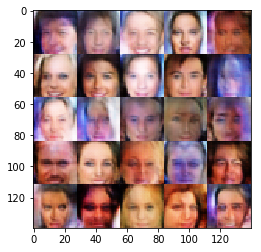

Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 1.2050
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 1.2597


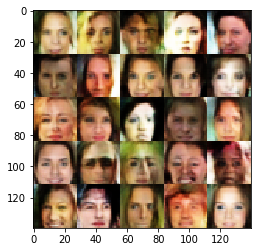

Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 1.2996
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 1.4177
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 0.8844
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.6842
Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 1.1783


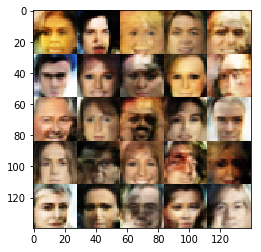

Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 1.0515
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.7532
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 1.3226
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 1.0694
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.9465


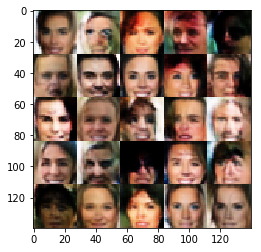

Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 1.5625
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 1.3638
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 1.1211
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 0.7289


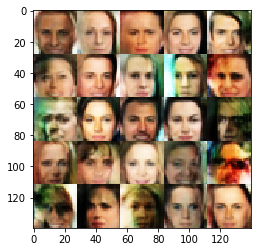

Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.9680
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 1.2234
Epoch 1/1... Discriminator Loss: 0.9437... Generator Loss: 1.1050
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 0.8377


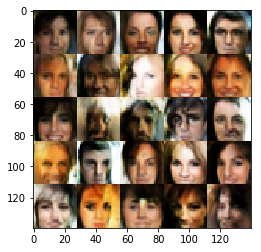

Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 0.9764
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 0.9303
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 1.3041
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 1.0035


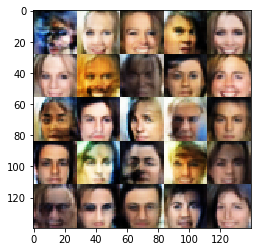

Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 1.1777
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 1.0422
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.8658


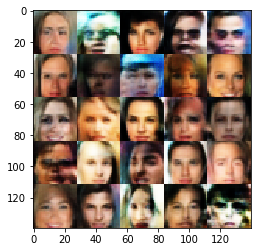

Epoch 1/1... Discriminator Loss: 1.1341... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.4233
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 0.9901


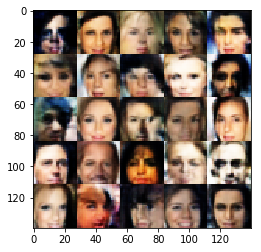

Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 1.1571
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 1.0231
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.0381... Generator Loss: 1.3648
Epoch 1/1... Discriminator Loss: 1.1117... Generator Loss: 0.9835


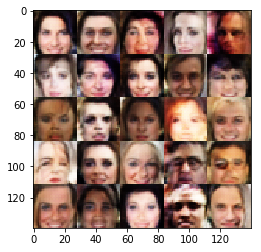

Epoch 1/1... Discriminator Loss: 1.1376... Generator Loss: 1.5685
Epoch 1/1... Discriminator Loss: 1.2015... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 1.0735
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 0.8998
Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 0.6249


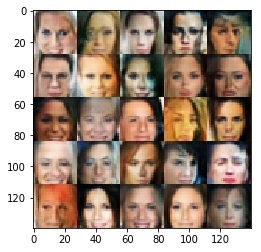

Epoch 1/1... Discriminator Loss: 1.0274... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.1794... Generator Loss: 1.4607
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 1.0514
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.4955


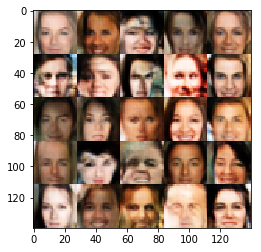

Epoch 1/1... Discriminator Loss: 1.0477... Generator Loss: 1.2248
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 0.8902
Epoch 1/1... Discriminator Loss: 1.2064... Generator Loss: 1.4146
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 0.9834
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.6622


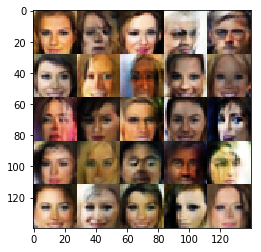

Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 1.2193
Epoch 1/1... Discriminator Loss: 1.1727... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 1.2217... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.7723


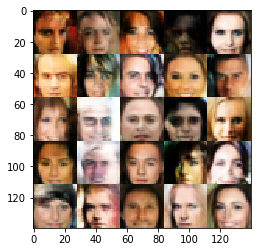

Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.9588
Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 1.3631
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 0.9400
Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 0.9112


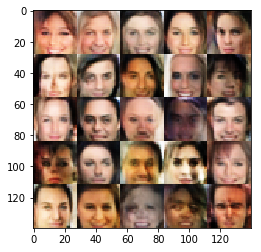

Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.8934
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 1.0876
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 1.0578
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.6080


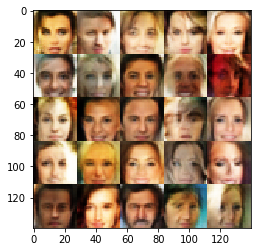

Epoch 1/1... Discriminator Loss: 1.0626... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.5137
Epoch 1/1... Discriminator Loss: 1.1739... Generator Loss: 1.0869
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.9524


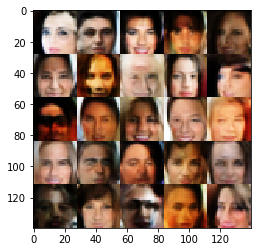

Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 1.3013
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 1.3168
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 1.3679
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.5529
Epoch 1/1... Discriminator Loss: 1.0439... Generator Loss: 1.1219


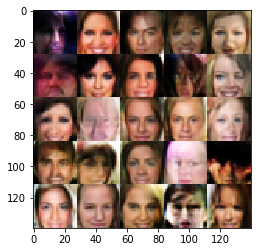

Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 1.2911
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 1.2577
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 1.2708
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 0.5655


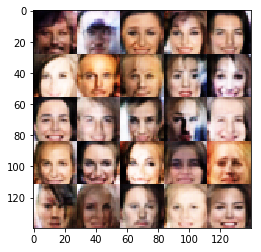

Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 1.1449
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.7340
Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.5429


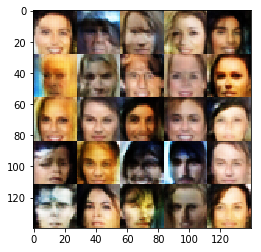

Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 1.0538
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.0438
Epoch 1/1... Discriminator Loss: 0.8944... Generator Loss: 1.4584
Epoch 1/1... Discriminator Loss: 1.0887... Generator Loss: 1.0023
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 0.8436


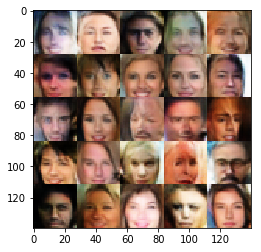

Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.5007
Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 1.0453
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 1.2544
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.6087


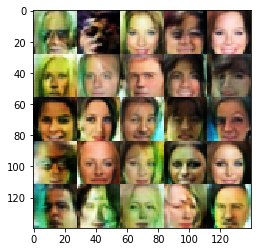

Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 1.0989
Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 0.8756
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 0.8933
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 1.0123


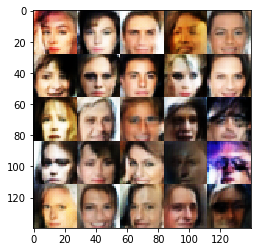

Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 0.9866
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 1.1387
Epoch 1/1... Discriminator Loss: 0.9861... Generator Loss: 0.9900
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.4592
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.9133


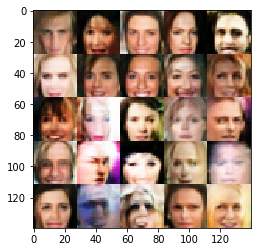

Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 0.9957
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 1.4792
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.4396
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 1.0562


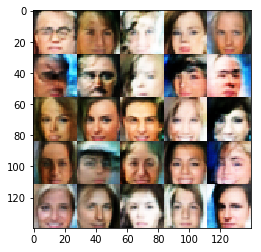

Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 0.9237
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.1024
Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 1.1705
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 1.3476


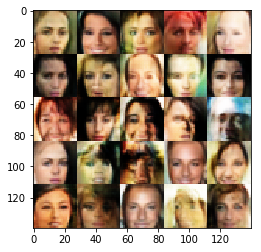

Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 0.6331
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 1.6675
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 1.0392
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 0.5953


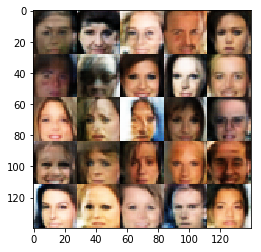

Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.4882
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 1.1576
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.3718


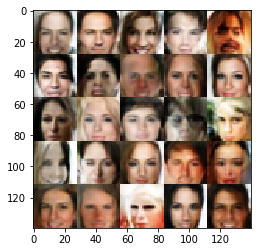

Epoch 1/1... Discriminator Loss: 1.1732... Generator Loss: 1.0974
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 1.2294
Epoch 1/1... Discriminator Loss: 1.1844... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.6095


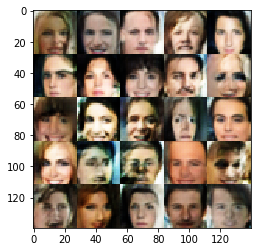

Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.5057
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.8845


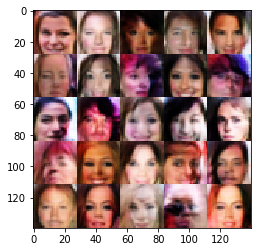

Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 1.1671
Epoch 1/1... Discriminator Loss: 0.8792... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 1.1669
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.8384


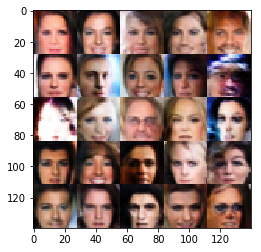

Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 1.0732
Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 0.8751
Epoch 1/1... Discriminator Loss: 0.9559... Generator Loss: 1.0248
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 1.0594
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.6480


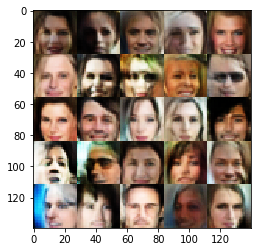

Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 0.8710
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.0230... Generator Loss: 1.1661


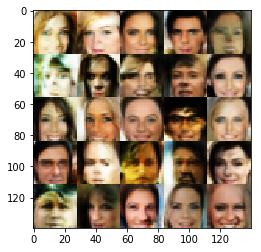

Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.8792
CPU times: user 13min 31s, sys: 3min 40s, total: 17min 11s
Wall time: 20min 49s


In [13]:
%%time
batch_size = 32
z_dim = 128
learning_rate = 0.0003
alpha = 0.06
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode, alpha = alpha)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.